In [612]:
# Import modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import utils.data_preprocessor as dp
from importlib import reload
from sklearn.preprocessing import StandardScaler
import utils.data_wrangling as wr
import utils.data_transformation as tr
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import utils.lasso_regression as lr
import utils.gradient_boost_regression as gb
import utils.LSTM as lstm
import utils.eda_visuals as viz
from sklearn.linear_model import Ridge
import utils.model_training as mlt
import utils.standardization_and_pca as spca
import utils.prophet as pht
# add reload to ensure we have latest working version in cache
modules = [mlt, dp, wr, tr, lr, gb, lstm, viz, spca, pht]
for module in modules:
    reload(module)



In [527]:

# Reading in the csv files
stock_data = dp.read_data('data/stock_data.csv')
unemployment = dp.read_data('data/SeriesReport.csv')

In [528]:
# Print list of missing values per column and preview of df
dp.print_missing(stock_data)
stock_data.head()

dt has 0 missing values
vix has 0 missing values
sp500 has 0 missing values
sp500_volume has 0 missing values
djia has 0 missing values
djia_volume has 0 missing values
hsi has 0 missing values
ads has 0 missing values
us3m has 0 missing values
joblessness has 0 missing values
epu has 0 missing values
GPRD has 0 missing values
prev_day has 0 missing values


,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051,359.690002
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804,358.760010
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675,355.670013
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156,352.200012
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669,353.790009


In [529]:
# Print list of missing values per column and preview of df
dp.print_missing(unemployment)
unemployment.head()

Year has 0 missing values
Jan has 0 missing values
Feb has 0 missing values
Mar has 0 missing values
Apr has 0 missing values
May has 0 missing values
Jun has 0 missing values
Jul has 0 missing values
Aug has 0 missing values
Sep has 0 missing values
Oct has 0 missing values
Nov has 0 missing values
Dec has 0 missing values


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1990,5.4,5.3,5.2,5.4,5.4,5.2,5.5,5.7,5.9,5.9,6.2,6.3
1,1991,6.4,6.6,6.8,6.7,6.9,6.9,6.8,6.9,6.9,7.0,7.0,7.3
2,1992,7.3,7.4,7.4,7.4,7.6,7.8,7.7,7.6,7.6,7.3,7.4,7.4
3,1993,7.3,7.1,7.0,7.1,7.1,7.0,6.9,6.8,6.7,6.8,6.6,6.5
4,1994,6.6,6.6,6.5,6.4,6.1,6.1,6.1,6.0,5.9,5.8,5.6,5.5


## Exploratory Data Analysis

In [530]:
stock_data = wr.date_transform(stock_data, 'dt')

unemployment_unpivot = wr.unpivot_df(unemployment)

unemployment_unpivot_mapping = wr.mapping_month_names(unemployment_unpivot, 'Month')

stock_data_final = wr.merge_dfs(stock_data, unemployment_unpivot)

# Returning the First Five Records
stock_data_final.head()


,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day,Year,Month,Unemployment Percent
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051,359.690002,1990,1,5.4
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804,358.760010,1990,1,5.4
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675,355.670013,1990,1,5.4
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156,352.200012,1990,1,5.4
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669,353.790009,1990,1,5.4


In [531]:
# Returning Information on the DataFrame
stock_data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8597 entries, 0 to 8596
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   dt                    8597 non-null   datetime64[ns]
 1   vix                   8597 non-null   float64       
 2   sp500                 8597 non-null   float64       
 3   sp500_volume          8597 non-null   float64       
 4   djia                  8597 non-null   float64       
 5   djia_volume           8597 non-null   float64       
 6   hsi                   8597 non-null   float64       
 7   ads                   8597 non-null   float64       
 8   us3m                  8597 non-null   float64       
 9   joblessness           8597 non-null   int64         
 10  epu                   8597 non-null   float64       
 11  GPRD                  8597 non-null   float64       
 12  prev_day              8597 non-null   float64       
 13  Year              

In [532]:
# Returning Descriptive Statistics on the Data
stock_data_final.describe()

,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day,Year,Month,Unemployment Percent
count,8597,8597.000000,8597.000000,8.597000e+03,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000
mean,2007-01-19 10:42:31.866930432,19.560306,1596.652238,2.463780e+09,13662.535273,183.166216,16763.460949,-0.158047,2.690266,2.492381,115.564631,109.435667,1596.111831,2006.551704,6.521345,5.758160
min,1990-01-03 00:00:00,9.140000,295.459991,1.499000e+07,2365.100000,1.590000,2736.600098,-26.418300,0.000000,1.000000,57.202620,9.491598,295.459991,1990.000000,1.000000,3.400000
25%,1998-07-06 00:00:00,13.850000,898.700012,6.467400e+08,8038.570000,63.720000,10722.799805,-0.383563,0.180000,1.000000,85.925868,72.857056,897.989990,1998.000000,4.000000,4.500000
50%,2007-01-22 00:00:00,17.730000,1270.199951,2.521000e+09,10846.290000,177.830000,16803.759766,-0.045977,2.300000,2.000000,106.115769,96.603577,1270.089966,2007.000000,7.000000,5.400000
75%,2015-08-04 00:00:00,22.960000,2058.899902,3.834320e+09,17635.390000,272.590000,22867.330078,0.247940,4.990000,3.000000,137.077404,129.159744,2058.689941,2015.000000,10.000000,6.700000
max,2024-02-16 00:00:00,82.690000,5029.730000,1.145623e+10,38797.900000,922.680000,33154.121094,9.482140,8.260000,4.000000,350.459817,1045.603638,5029.730000,2024.000000,12.000000,14.800000
std,NaN,7.902780,1106.241259,1.847305e+09,9022.864862,133.671305,7350.096474,1.651492,2.296294,1.117501,41.579530,64.568210,1105.710429,9.855177,3.437762,1.748314


In [533]:
# Extracting the Desired Columns
stock_data_sample = stock_data_final.select_dtypes(include = 'number').columns.tolist()

# Creating a Dictionary to Map the Variable Names to
column_name_mapping = {
    'vix': 'Volatility Index (VIX)',
    'us3m': 'U.S. Treasury 3-Month Bond Yield',
    'epu': 'Economic Policy Uncertainty Index',
    'GPRD': 'Geopolitical Risk Index',
    'Unemployment Percent': 'Unemployment Percent',
    'sp500': 'S&P 500 Index',
    'sp500_volume': 'S&P 500 Trading Volume',
    'djia': 'Dow Jones Industrial Average',
    'djia_volume': 'Dow Jones Industrial Average Trading Volume',
    'hsi': 'Hang Seng Index',
    'ads': 'Aruoba-Diebold-Scotti Business Conditions Index'
}

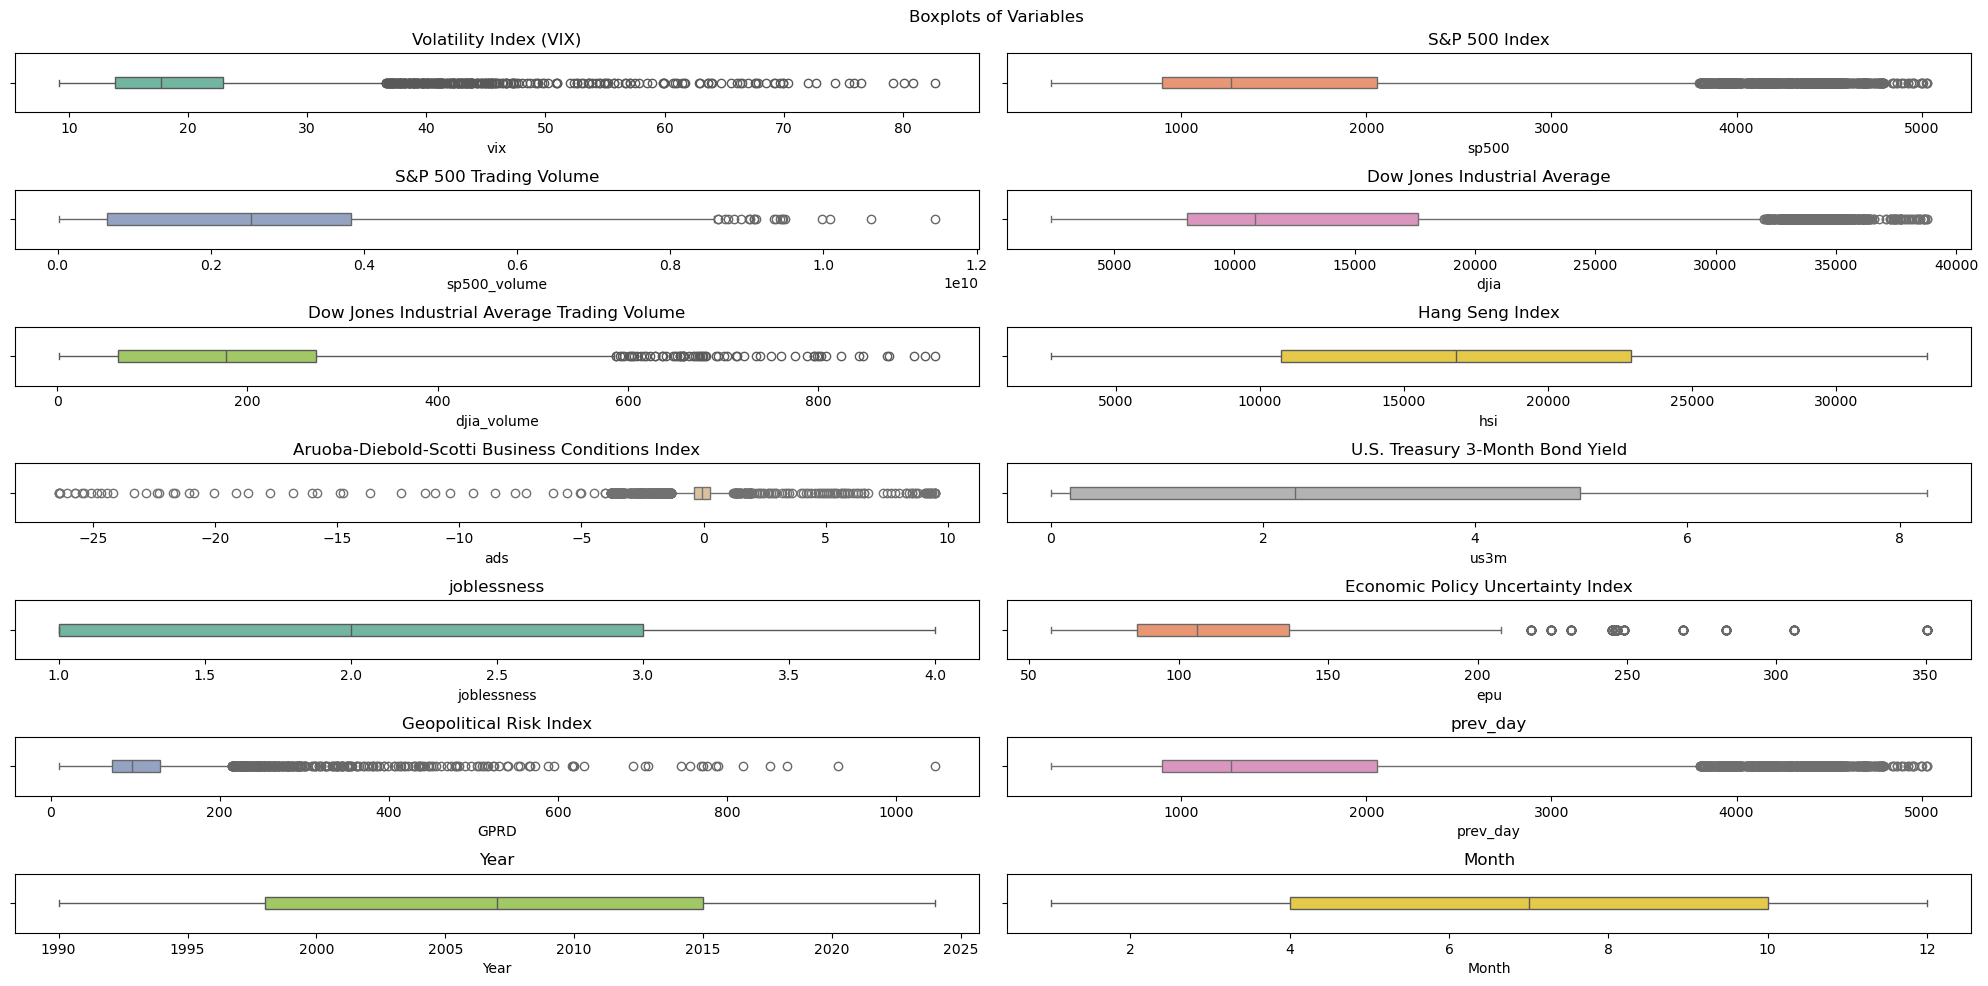

In [534]:
viz.boxplot_visuals(stock_data_final, stock_data_sample, column_name_mapping, 'Boxplots of Variables')

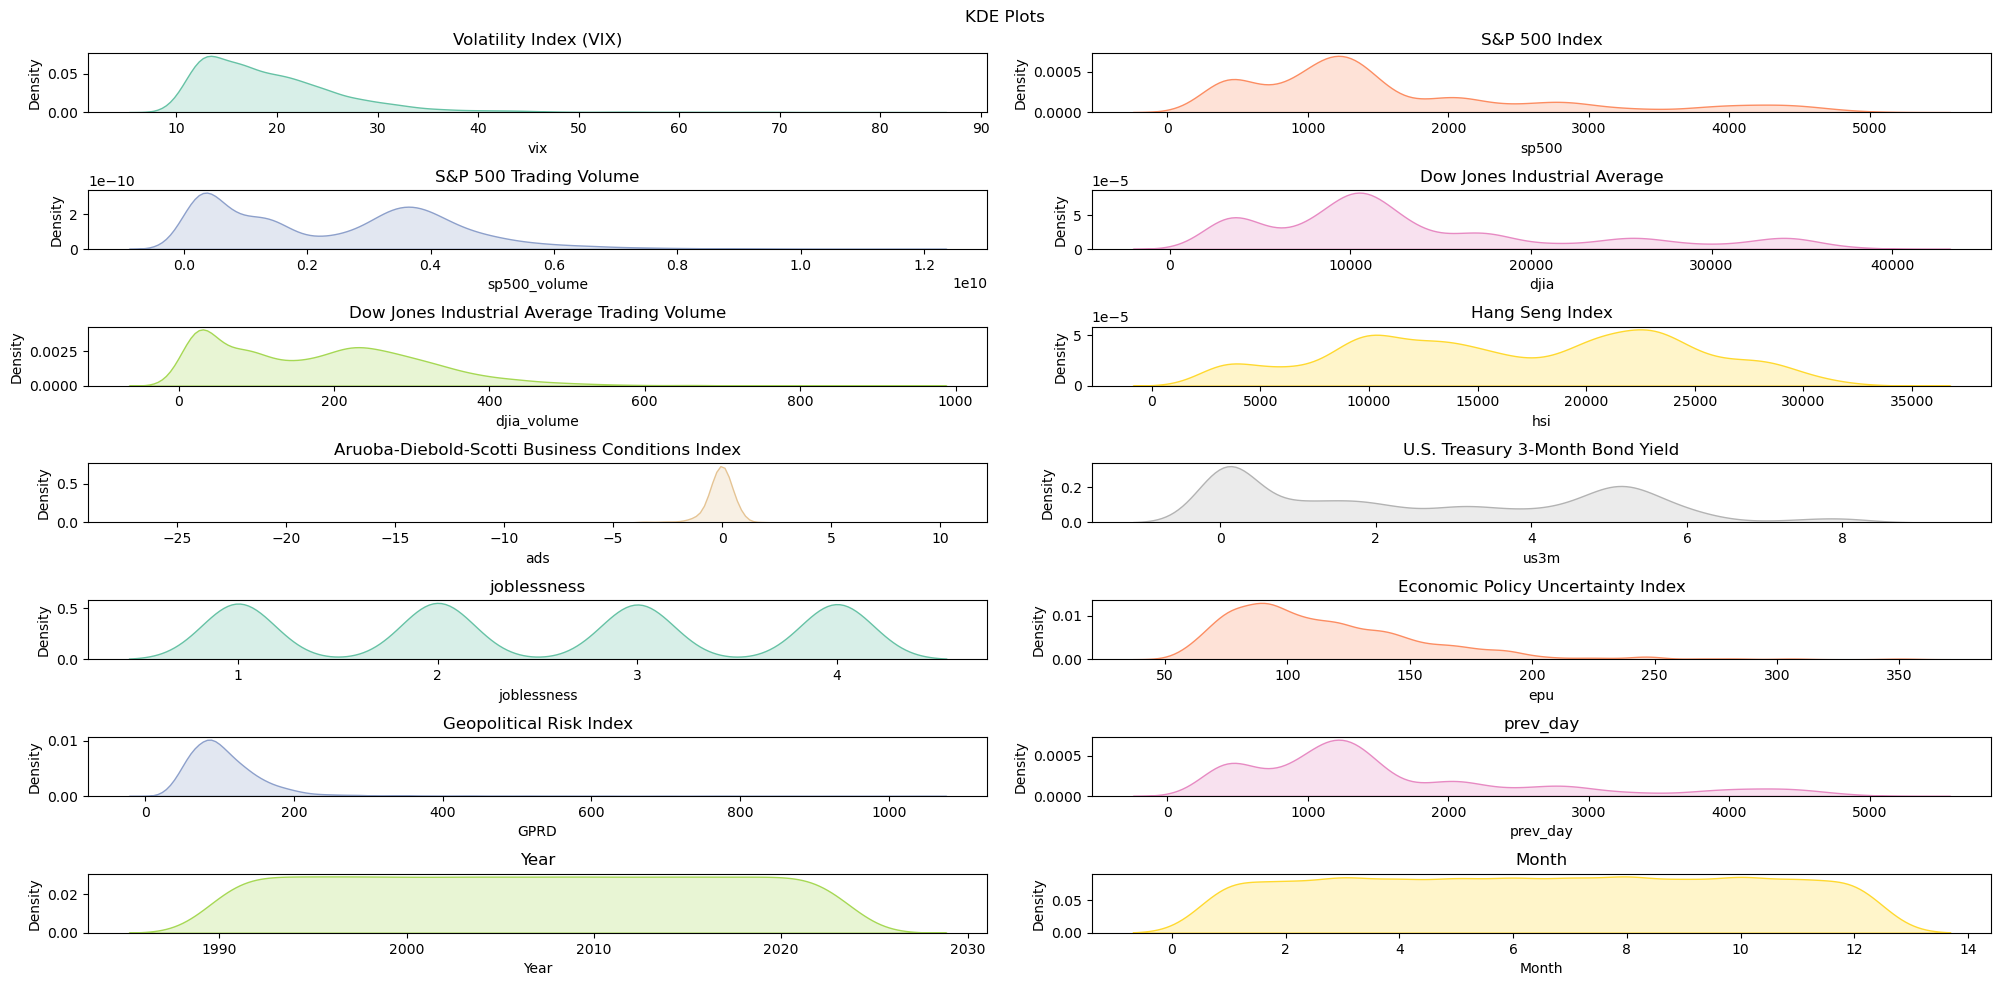

In [535]:
viz.kde_visuals(stock_data_final, stock_data_sample, column_name_mapping, 'KDE Plots')

<Figure size 800x600 with 0 Axes>

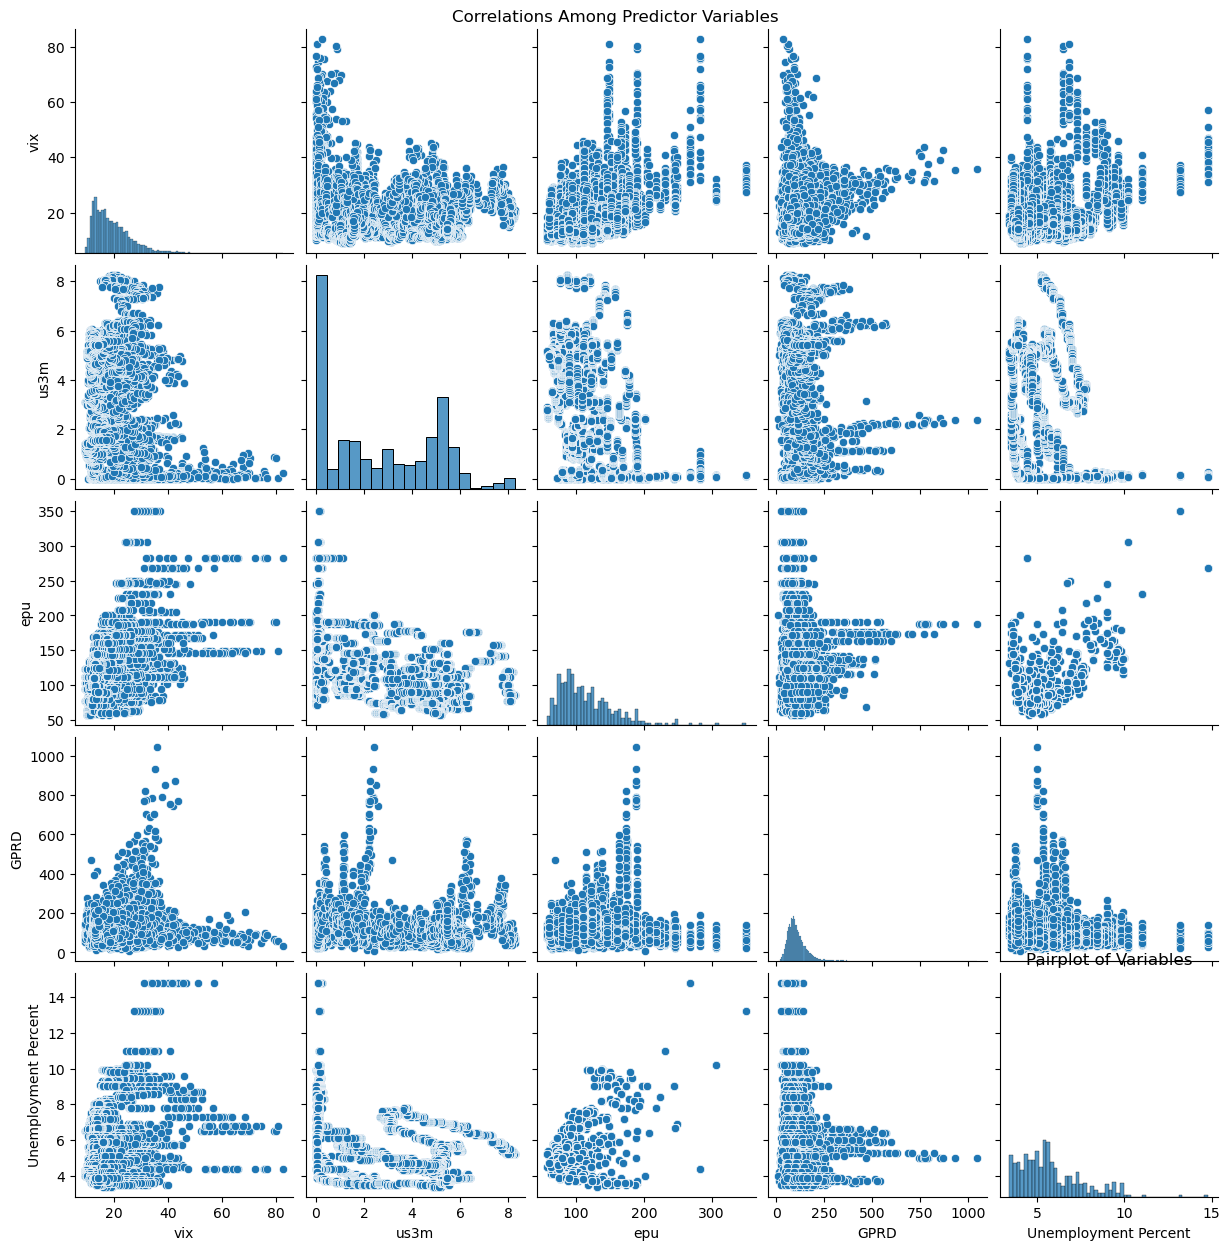

In [536]:
# Creating a Subset of Columns for the Pairplot
stock_data_subset = stock_data_final[['vix', 'us3m', 'epu', 'GPRD', 'Unemployment Percent']]

viz.pairplot_visual(stock_data_subset, 'Pairplot of Variables')

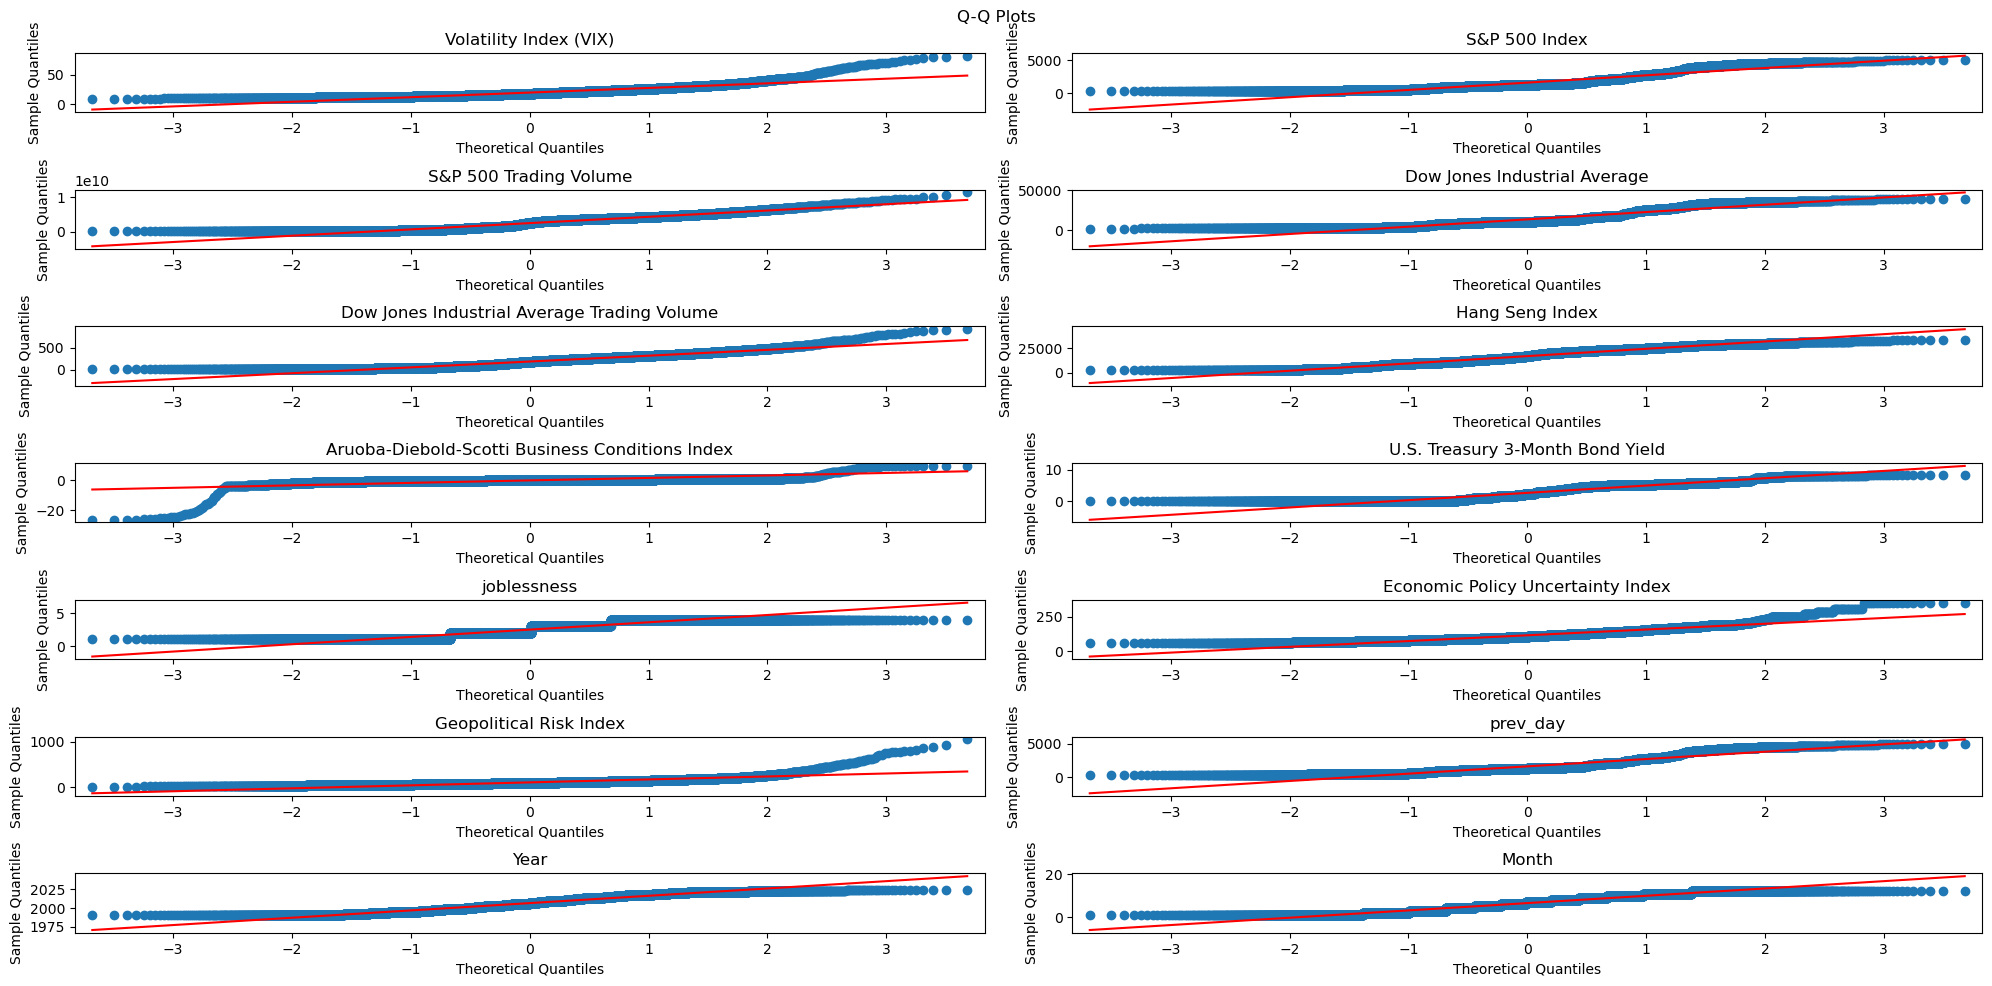

In [537]:
viz.qq_plot(stock_data_final, stock_data_sample, column_name_mapping, 'Q-Q Plots')

### Performing Log Transfomartions

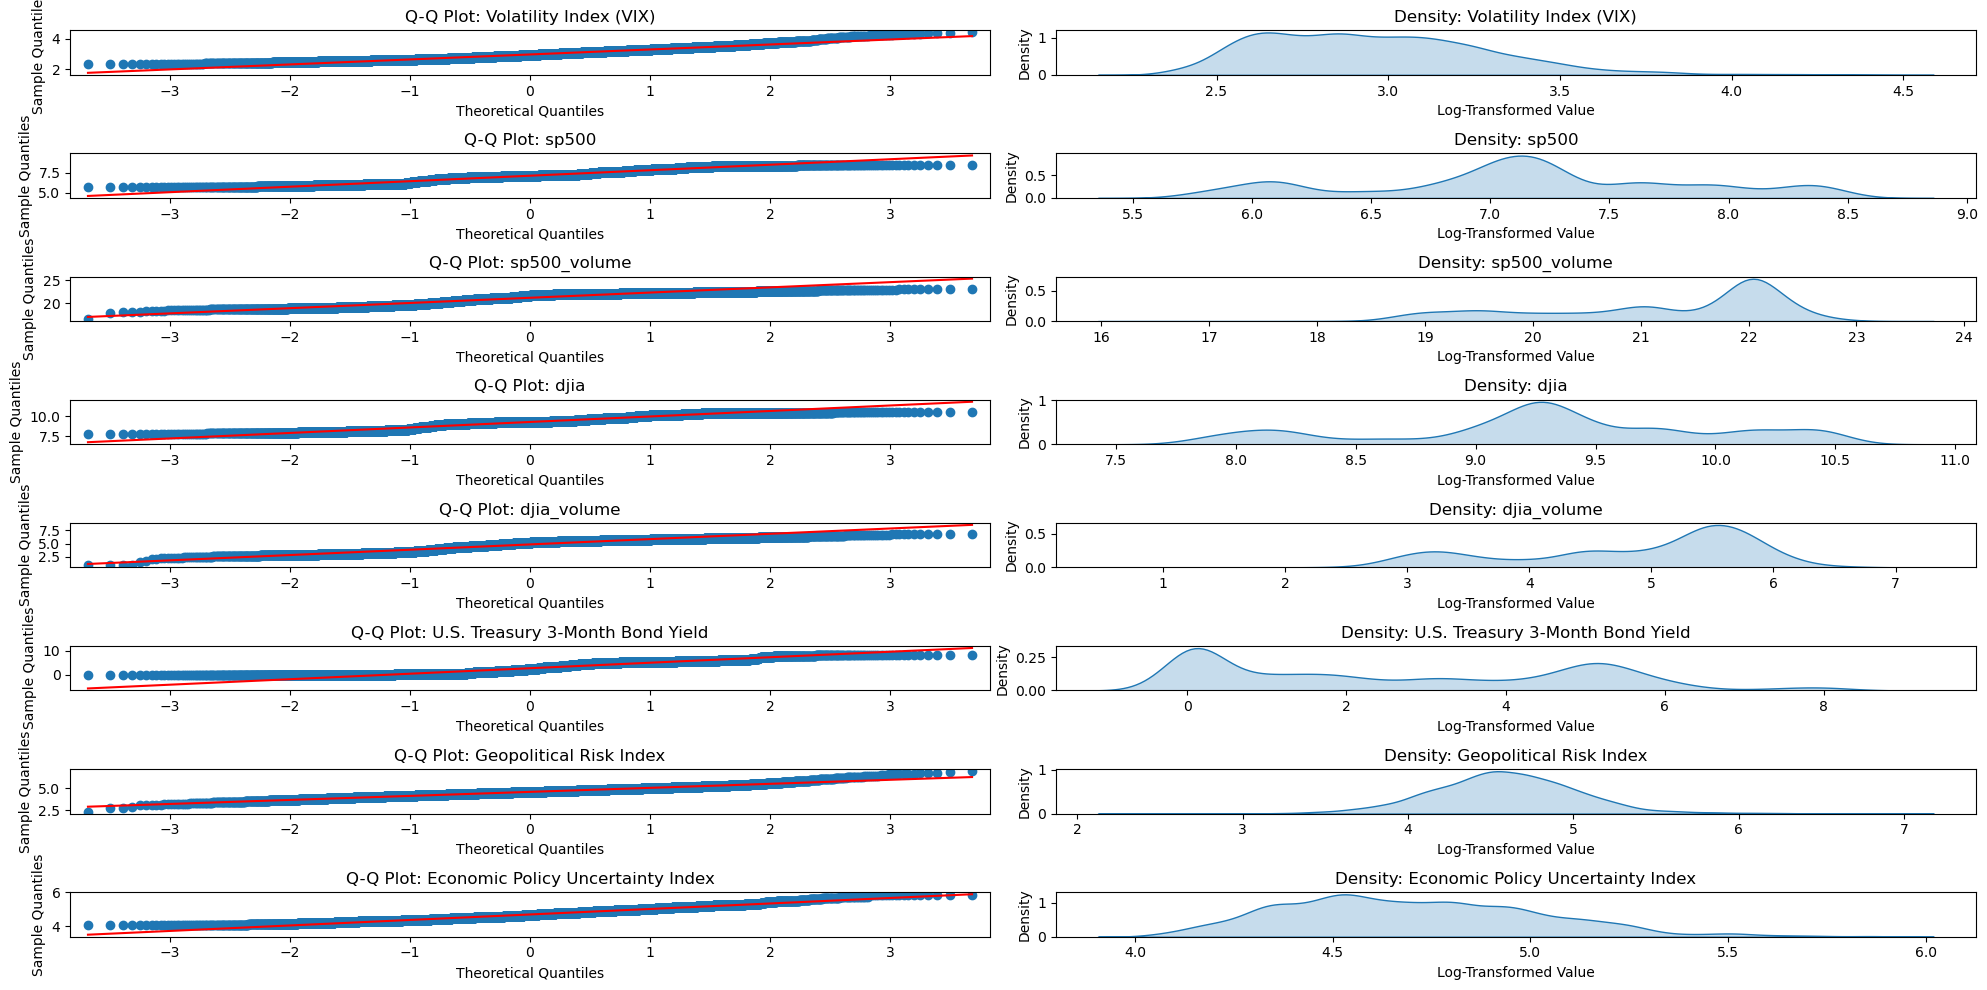

In [538]:
# Initializing a Variable with a Subset of Columns that need to be Log Transformed
numeric_columns_log_transform = stock_data_final[['vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'us3m', 'GPRD', 'epu']]

stock_data_final = tr.log_transform(stock_data_final, columns = numeric_columns_log_transform)

In [539]:

# Initializing a List of Numerical Columns
numeric_columns = stock_data_final.select_dtypes(include = 'number').columns

# Dropping the Response Variable from Standardization
numeric_columns = numeric_columns.drop('vix')

# Initializing a Variable to Standardize the Numeric Features
scaler = StandardScaler()

# Standardizing the Numeric Features
stock_data_final[numeric_columns] = scaler.fit_transform(stock_data_final[numeric_columns])

# Dropping the Year and Month Columns
stock_data_final = stock_data_final.drop(columns = ['Year', 'Month'])

# Confirming that the features were standardized
stock_data_final.head()


,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day,Unemployment Percent
0,1990-01-03,2.954389,-1.832528,-1.839832,-1.930427,-1.655867,-1.891889,-0.043521,2.264534,0.454271,-0.264655,-0.556686,-1.118280,-0.204872
1,1990-01-04,3.006672,-1.845048,-1.913103,-1.937364,-1.625504,-1.890624,-0.053299,2.242758,0.454271,-0.264655,-1.193000,-1.119121,-0.204872
2,1990-01-05,3.049747,-1.859237,-2.010316,-1.949042,-1.802909,-1.894447,-0.061975,2.220983,0.454271,-0.264655,-0.914744,-1.121916,-0.204872
3,1990-01-08,3.056827,-1.852718,-2.119270,-1.938235,-1.994927,-1.897699,-0.080964,2.220983,0.454271,-0.264655,0.112896,-1.125054,-0.204872
4,1990-01-09,3.144152,-1.869878,-2.028986,-1.952770,-2.042572,-1.896883,-0.084340,2.225338,0.454271,-0.264655,0.756213,-1.123616,-0.204872


### Principal Component Analysis

In [540]:
stock_data_final_standardized = spca.standardize_data(stock_data_final, 'vix')

In [541]:
stock_data_final_standardized.isna().sum()

dt                      0
vix                     0
sp500                   0
sp500_volume            0
djia                    0
djia_volume             0
hsi                     0
ads                     0
us3m                    0
joblessness             0
epu                     0
GPRD                    0
prev_day                0
Unemployment Percent    0
dtype: int64

In [542]:
stock_data_final_pca = spca.pca_transformation(stock_data_final_standardized, 'vix', 2)

In [543]:
stock_data_final_pca.head()

,dt,Principal Component 1,Principal Component 2,vix
0,1990-01-03,-4.609702,-0.836126,2.954389
1,1990-01-04,-4.647602,-0.860661,3.006672
2,1990-01-05,-4.745500,-0.859533,3.049747
3,1990-01-08,-4.818650,-0.839723,3.056827
4,1990-01-09,-4.795108,-0.799533,3.144152


### Lasso Regression

In [544]:
# Dropping the Date Columns
stock_data_final_no_date = stock_data_final_standardized.drop(columns = ['dt'])

print('Original Lasso Regression Results:')
print(lr.lasso_regression(stock_data_final_no_date, 'vix', 1.0, 42),'\n')


print('Lasso Regression Results with Hyperparameter Tuning:')
print(lr.lasso_hyperparameter_tuning(stock_data_final_no_date, 'vix', 5, 100000, 42))

Original Lasso Regression Results:
Mean Squared Error: 0.10806197639498576
R-Squared: -0.00017192695750201104 

Lasso Regression Results with Hyperparameter Tuning:
Mean Squared Error: 0.05565627855442422
R-Squared: 0.484871096882465


/Users/emmagore/Desktop/GitHub/INFO-523-Notes/.conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e+01, tolerance: 7.516e-02
  model = cd_fast.enet_coordinate_descent(


### Gradient Boost Regression

In [545]:
# Dropping the Date Columns
stock_data_final_no_date_pca = stock_data_final_pca.drop(columns = ['dt'])

# Performing Gradient Boost with PCA Applied
print('Gradient Boost Regression Results with PCA Applied:\n')
print('Original Gradient Boost Regression Results:')
print(gb.gradient_boost(stock_data_final_no_date_pca, 'vix', 100, 42), '\n')

# Defining a Parameter Grid
param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }

# Performing Gradient Boost with PCA and Hyperparameter Tuning Applied
print('Gradient Boost Regression Results with Hyperparameter Tuning:')
print(gb.gradient_boost_hyperparameter_tuning(stock_data_final_no_date_pca, 'vix', param_grid, 5, 42))

Gradient Boost Regression Results with PCA Applied:

Original Gradient Boost Regression Results:
Mean Squared Error: 0.04436085651029851
R-Squared: 0.589416325542522 

Gradient Boost Regression Results with Hyperparameter Tuning:
Mean Squared Error: 0.03413475003135323
R-Squared: 0.6840644613949945


In [546]:
# Performing Gradient Boost without PCA Applied
print('Gradient Boost Regression Results without PCA Applied:\n')
print('Original Gradient Boost Regression Results:')
print(gb.gradient_boost(stock_data_final_no_date, 'vix', 100, 42), '\n')

print('Gradient Boost Regression Results with Hyperparameter Tuning:')
print(gb.gradient_boost_hyperparameter_tuning(stock_data_final_no_date, 'vix', param_grid, 5, 42))

Gradient Boost Regression Results without PCA Applied:

Original Gradient Boost Regression Results:
Mean Squared Error: 0.01533574541828602
R-Squared: 0.8580593974121637 

Gradient Boost Regression Results with Hyperparameter Tuning:
Mean Squared Error: 0.004363473883794131
R-Squared: 0.9596136936582476


### Long Short-Term Memory (LSTM)

In [547]:
print(lstm.lstm_function(stock_data_final_no_date, 'vix'))

/Users/emmagore/Desktop/GitHub/INFO-523-Notes/.conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1729 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error: 0.7701375067007454
R-Squared: -5.541718367908695


### Prophet

  0%|          | 0/64 [00:00<?, ?it/s]

Mean Squared Error: 0.0478
R-Squared: 0.5618
Performance Metrics:
     horizon       mse      rmse       mae      mape     mdape     smape  \
0    37 days  0.095137  0.308443  0.207439  0.067017  0.048849  0.068369   
1    38 days  0.094912  0.308078  0.207560  0.067100  0.049251  0.068419   
2    39 days  0.093998  0.306591  0.206828  0.066898  0.049251  0.068180   
3    40 days  0.093908  0.306445  0.207124  0.067021  0.049375  0.068312   
4    41 days  0.094935  0.308115  0.208566  0.067485  0.049448  0.068803   
..       ...       ...       ...       ...       ...       ...       ...   
324 361 days  0.194616  0.441153  0.342278  0.115326  0.095725  0.114848   
325 362 days  0.195507  0.442161  0.343047  0.115472  0.095991  0.115101   
326 363 days  0.195714  0.442396  0.343558  0.115583  0.095991  0.115239   
327 364 days  0.195899  0.442605  0.343868  0.115656  0.096847  0.115307   
328 365 days  0.197019  0.443868  0.344626  0.115895  0.097090  0.115585   

     coverage  
0    

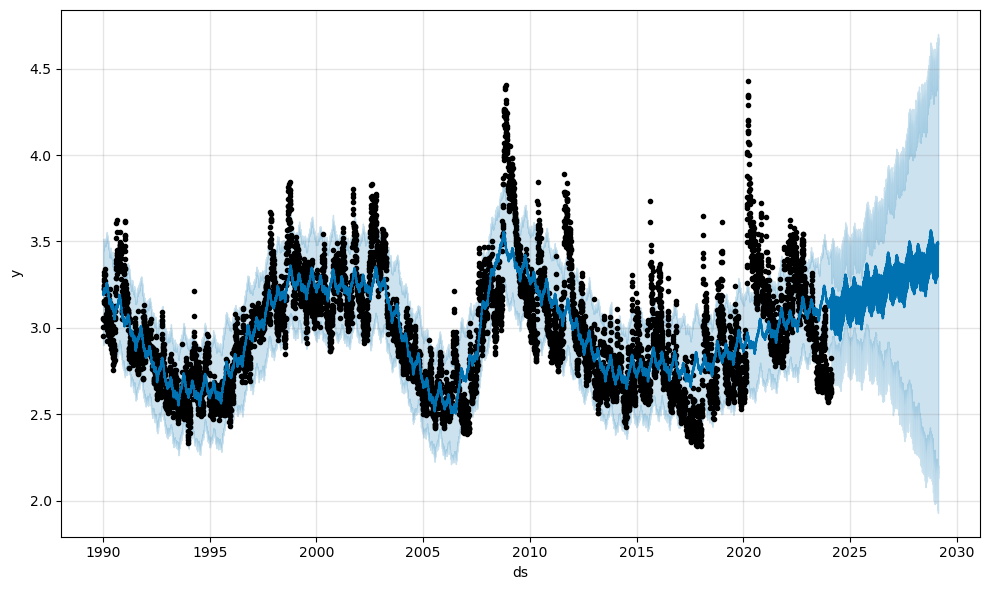

In [613]:
# Removing the Unnecessary Columns from the Analysis
stock_data_prophet = stock_data_final_standardized[['dt', 'vix']]

print(pht.prophet_model(stock_data_prophet, 1827, '730 days', '180 days', '365 days'))

## Ridge

In [549]:
# split train/test data
y = stock_data['vix'].to_numpy()
jobless = stock_data_final['joblessness'].to_numpy().reshape(-1, 1)
us3m   = stock_data_final['us3m'].to_numpy().reshape(-1, 1)\
# one split on indices so everything stays aligned\n",
idx = np.arange(len(y))
idx_train, idx_test = train_test_split(
    idx,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
# slice all arrays with the SAME indices
X_unemployment_train = jobless[idx_train]
X_unemployment_test  = jobless[idx_test]

X_bond_train = us3m[idx_train]
X_bond_test  = us3m[idx_test]
X_bond_jobless_train = np.hstack([X_unemployment_train, X_bond_train])
X_bond_jobless_test  = np.hstack([X_unemployment_test, X_bond_test])

y_train = y[idx_train]
y_test  = y[idx_test]

In [550]:
unemployment_ridge = Ridge()
bond_ridge = Ridge()
bond_unemployment_ridge = Ridge()
print(y_train)
batch_args = {
    unemployment_ridge: (X_unemployment_train, X_unemployment_test, 'Unemployment Ridge Model'),
    bond_ridge: (X_bond_train, X_bond_test, 'Bond Yield Ridge Model'),
    bond_unemployment_ridge : (X_bond_jobless_train, X_bond_jobless_test, 'Bond Yield Ridge & Unemployment Model')
}
mlt.batch_ridge(batch_args, y_train, y_test)

[12.49 11.43 17.39 ... 17.43 13.1  16.36]
Begining Batch Model Traing
------------------------------------------------
Starting training for Unemployment Ridge Model
Model results for Unemployment Ridge Model
Coefficients: [2.41130135]
Intercept: 19.59399618216382
MSE: 53.52527358425855
R^2: 0.09736849352362653
---------------------------------------------
Starting training for Bond Yield Ridge Model
Model results for Bond Yield Ridge Model
Coefficients: [-0.82344292]
Intercept: 19.574020376417163
MSE: 58.6193196701746
R^2: 0.011464280715590913
---------------------------------------------
Starting training for Bond Yield Ridge & Unemployment Model
Model results for Bond Yield Ridge & Unemployment Model
Coefficients: [ 2.34762818 -0.55014837]
Intercept: 19.587718685495428
MSE: 53.17808010982467
R^2: 0.10322344293128705
---------------------------------------------
